This notebook helps remove high frequency electrical noise from the UCLA Miniscope v4 EWL that contaminates simultaneously recorded electrophysiological signal by using the filtering functionality in [SpyKing Circus](https://spyking-circus.readthedocs.io/en/latest/).

## CRUCIAL NOTE
This notebook will OVERWRITE your ephys data file!!! Be sure to backup your files prior to running and always run on a copy of your file!

## Installation
This module uses [spyking-circus](https://spyking-circus.readthedocs.io/en/latest/) to notch filter your signal in specific frequency band.  

1) First, clone the `nkinsky` fork of spyking-circus: https://github.com/nkinsky/spyking-circus.
2) Next, checkout the `notch_filter` branch with: `>>> git checkout -b notch_filter` and pull any changes with: `>>> git pull origin notch_filter`
3) Run the spyking-circus ["Using sources" installation instructions](https://spyking-circus.readthedocs.io/en/latest/introduction/install.html#using-sources OR ...
4) you can install a few dependencies with: `conda install -c conda-forge mpi4py python-blosc` and `pip install pyqt5`
5) Next, clone the `nkinsky` fork of NeuroPy: https://github.com/nkinsky/NeuroPy
6) Step through the code below, making sure to update locations where your github repositories and recording file are located.

IMPORTANT NOTE: This code was developed for binary .dat files recorded through OpenEphys recording software.

The `miniscope_denoise` function (in the nkinsky spyking-circus repository fork) should work with any file format supported by SpyKing Circus as long as you update the parameters in your .params file accordingly.

To visualize miniscope noise with `plot_miniscope_noise` (in the NeuroPy repository) prior to denoising you will need to write a few lines of custom code to wrangle your data file(s) into the appropriate format, noted below.

## De-noising code

### Import relevant functions

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path
import os

# Comment here to add in for either mac or linux computer
sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])  # Path to your neuropy module
sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/spyking-circus'])  # Add path to spyking-circus folder added above!

from neuropy import core
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
# from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.utils.miniscope_denoise import plot_miniscope_noise, check_filter

In [2]:
# Enter dat filename to use here: 
# Grab "ripple_channel_w_miniscope_noise.dat" from the "examples/Data" folder for an example of denoising a single channel.
dat_filename = "/Users/nkinsky/Documents/UM/Working/miniscope_denoise_testing/ripple_channel_w_miniscope_noise.dat"  # Sampled at 30kHz

### Check Signal Before Denoising to identify frequency bands of interest
Use the leftmost plot below to identify noise bands and their harmonics. Note that older miniscopes may have multiple different bands, and that the bands may shift in frequency with time.

For non .dat file formats, first read-in and wrangle your data file(s) into a single nchannels x nframes np.ndarray called `raw_traces` and then run the code below before plotting miniscope noise:  
```
from neuropy.core.signal import Signal
raw_traces = ## write custom code here to import your own data type
signal = Signal(raw_traces, sampling_rate)
```

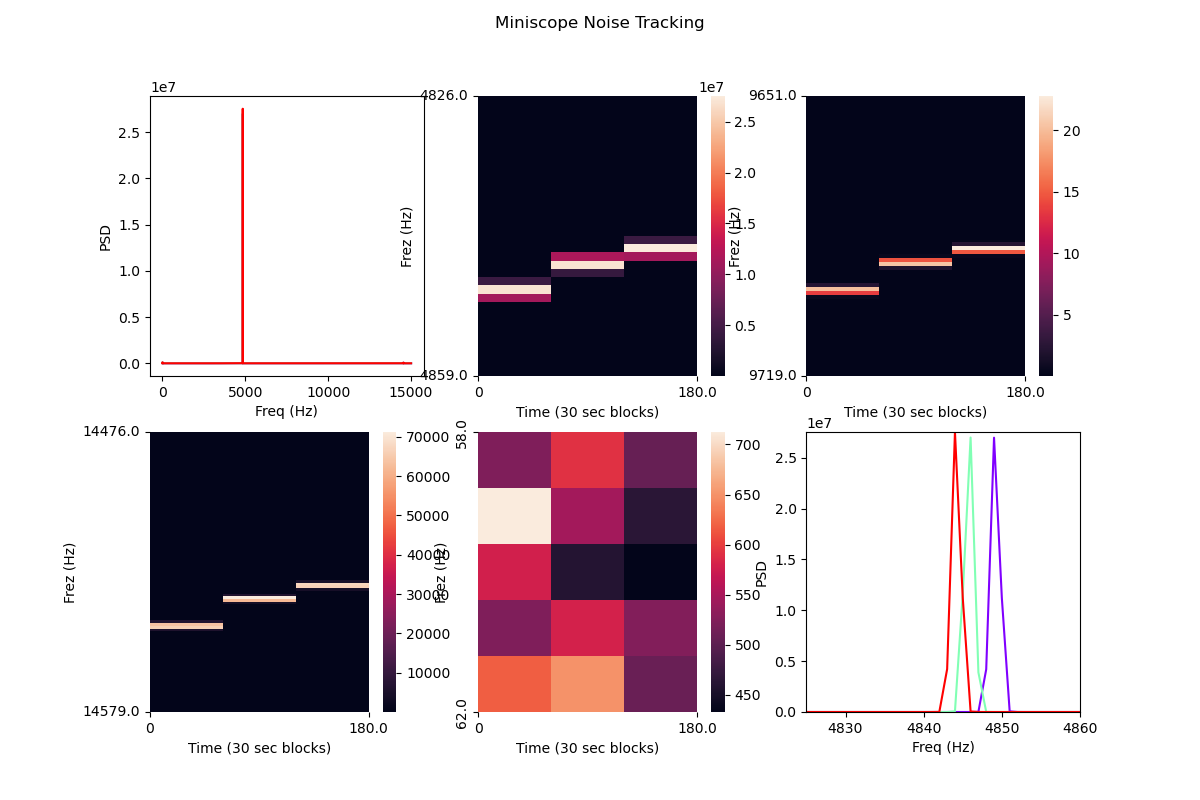

In [3]:
%matplotlib ipympl

# Import .dat file. Replace the following two lines with custom code above if using a different file format.
datfile = BinarysignalIO(dat_filename, n_channels=1, sampling_rate=30000)
signal = datfile.get_signal()

f_full, Pxx_full = plot_miniscope_noise(signal, ch=0, interval_sec=90, remove_disconnects=True,
                                        EWLnoise_range=(4825, 4860))

Example trace from first 3 seconds of the recording. Looks terrible

(0.0, 3.0)

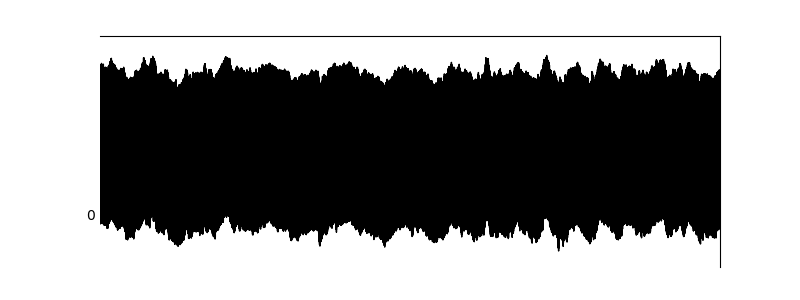

In [4]:
from neuropy.plotting.signals import plot_signal_traces
_, ax = plt.subplots(figsize=(8, 3))
plot_signal_traces(signal, ax=ax)
ax.set_xlim((0, 3))

Very clear noise in the 4840 to 4853 band and 2nd/3rd harmonics, which is expected since it coincides with the driving frequency of the EWL. You may uncover other bands in your data depending on the age of your miniscope.

### Perform Denoising

#### Set up .params file
- We are using spyking-circus to notch filter so we need to provide a spyking-circus.params file with the SAME NAME as your .dat file but with the .params suffix.
- Copy over the `ripple_channel_w_miniscope_noise.params`
- Make sure all the `[data]` parameters at the top match your file, in particular the `sampling_rate` (30000 here) and `nb_channels` (1 here)
- Set the `filter_done` flag toward the bottom in the `[noedits]` section to `False`.
- Finally, copy the `example_single_channel_probe_file.prb` file over and copy over the full path to the file in the `[data]` section, "mapping" parameter.
-- you will need to adjust this in line with the spyking-circus documentation for your full electrode design.

Check filter before running. Make sure filter values in rightmost plot are all negative. Any positive values will result in total devastation of your .dat file.  If you notice this occurring, you may need to split your filter up and run it twice.

In [5]:
%matplotlib widget

from circus.filtering import miniscope_filter
# dat_file = str(Path(os.getcwd()) / dat_filename)

# Setup your noise frequency bands here.
base_freq = 4847
notch_filter = [
            {"w0": base_freq, "bw": 40, "Q": None},  # Adjust width by varying "bw" paramater
            {"w0": 2 * base_freq, "bw": 40, "Q": None}, # 2nd harmonic
            {"w0": 3 * base_freq, "bw": 40, "Q": None}# 3rd harmonic
]

check_filter(notch_filter)

In [6]:
miniscope_filter(dat_filename, top_limit=0, notch_filter=notch_filter)

STARTING MINISCOPE DE-NOISING
padding_sec changed to 1 for notch filter
Filtering with pre-specified notch filter


100%|████████████████████████████████████|[00:00<00:00, 34.15it/s]


DAT FILE DE-NOISING FINISHED


### Check After Denoising
If necessary, re-run afterward

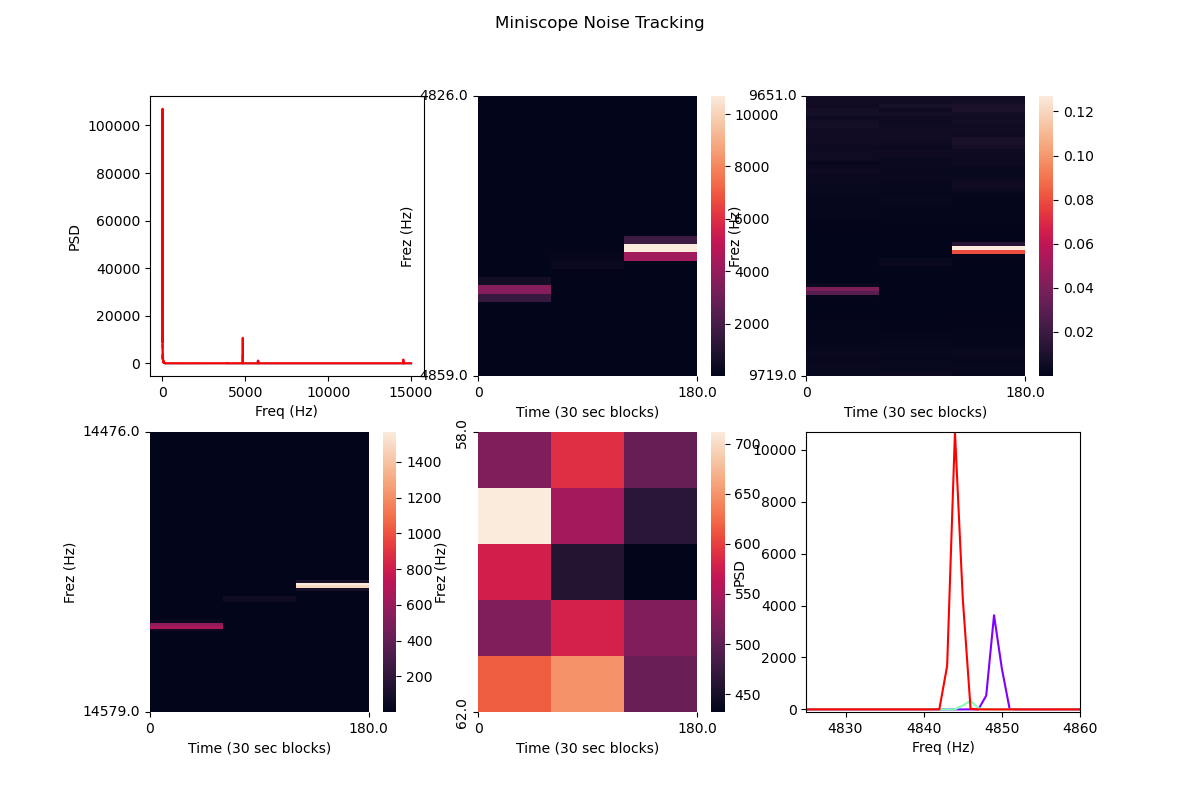

In [7]:
%matplotlib widget
datfile = BinarysignalIO(dat_filename, n_channels=1, sampling_rate=30000)

signal = datfile.get_signal()
f_full, Pxx_full = plot_miniscope_noise(signal, ch=0, interval_sec=90, remove_disconnects=True,
                                        EWLnoise_range=(4825, 4860))

Ok, so some it the noise got removed but it looks like my filter was too narrow. Re-run with a wider filter by adjusting the "bw" value below.  Make sure to reset the `filter_done` flag to False in the params file.

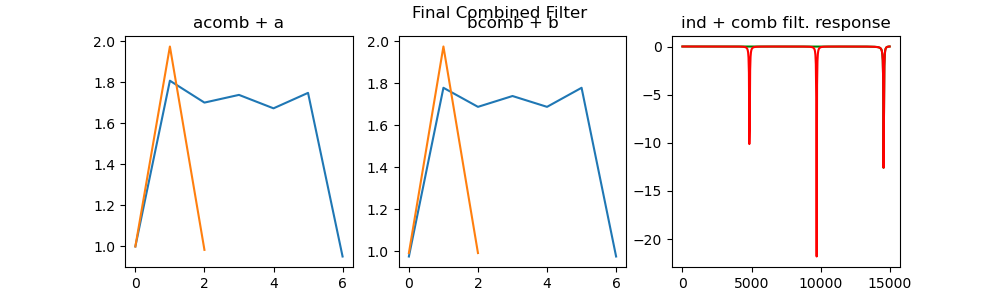

In [8]:
base_freq = 4847
notch_filter = [
            {"w0": base_freq, "bw": 80, "Q": None},  # Adjust width by varying "bw" paramater
            {"w0": 2 * base_freq, "bw": 80, "Q": None}, # 2nd harmonic
            {"w0": 3 * base_freq, "bw": 80, "Q": None}# 3rd harmonic
]
check_filter(notch_filter)

Re-run, being sure to set the `filter_done` line in your dat file to `False`

In [9]:
miniscope_filter(dat_filename, top_limit=0, notch_filter=notch_filter)

STARTING MINISCOPE DE-NOISING
padding_sec changed to 1 for notch filter
Filtering with pre-specified notch filter


100%|████████████████████████████████████|[00:00<00:00, 37.76it/s]


DAT FILE DE-NOISING FINISHED


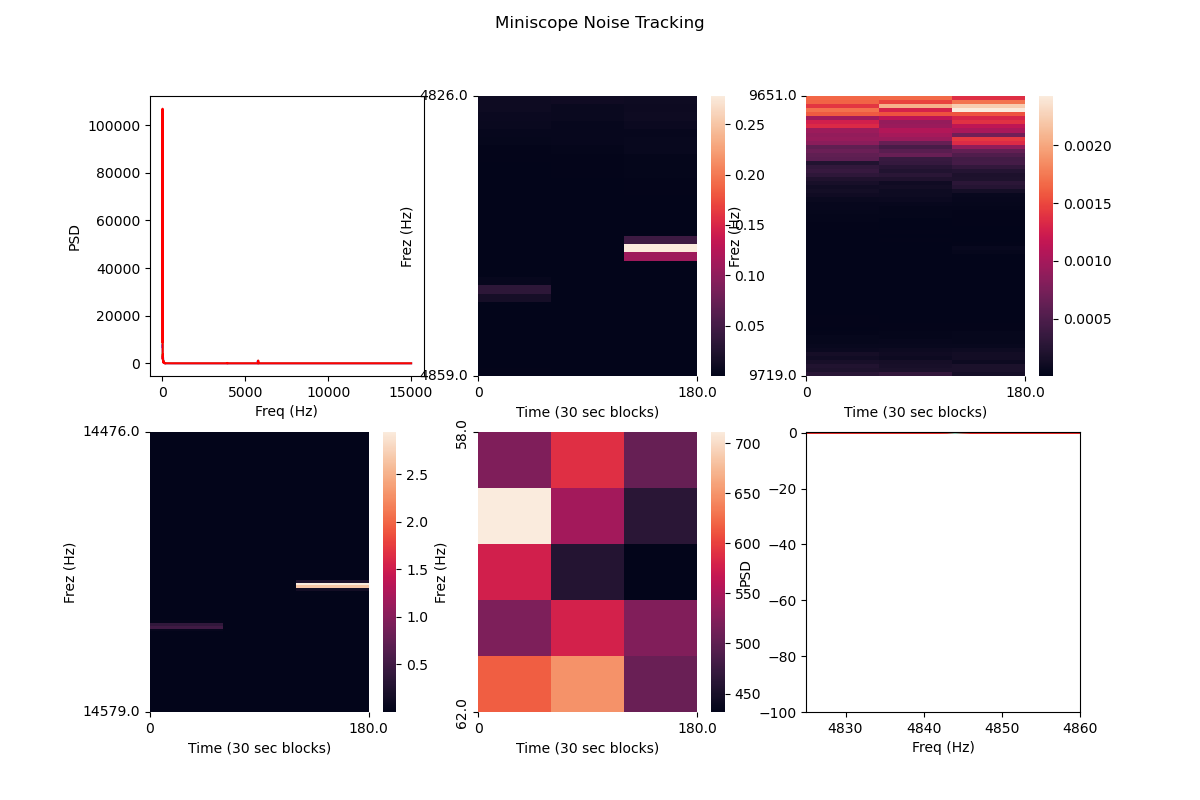

In [10]:
%matplotlib widget
datfile = BinarysignalIO(dat_filename, n_channels=1, sampling_rate=30000)

signal = datfile.get_signal()
f_full, Pxx_full = plot_miniscope_noise(signal, ch=0, interval_sec=90, remove_disconnects=True,
                                        EWLnoise_range=(4825, 4860))

Looks like I missed a secondary smaller band around 5770 , run one more time.

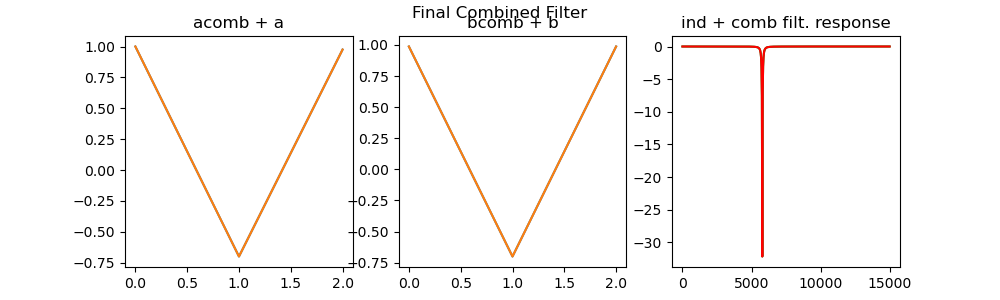

In [11]:
base_freq = 5770
notch_filter = [
            {"w0": base_freq, "bw": 120, "Q": None},  # Adjust width by varying "bw" paramater
]
check_filter(notch_filter)

In [12]:
miniscope_filter(dat_filename, top_limit=0, notch_filter=notch_filter)

STARTING MINISCOPE DE-NOISING
padding_sec changed to 1 for notch filter
Filtering with pre-specified notch filter


100%|████████████████████████████████████|[00:00<00:00, 38.64it/s]


DAT FILE DE-NOISING FINISHED


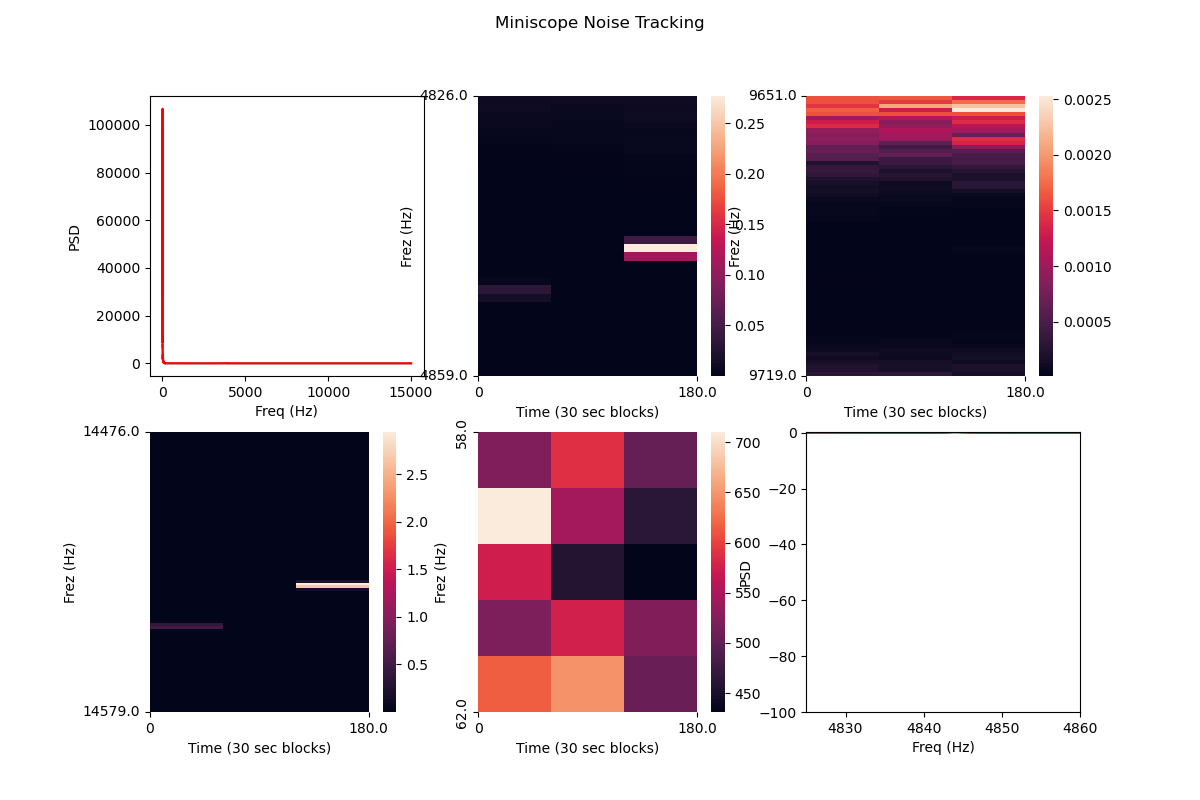

In [13]:
%matplotlib widget
datfile = BinarysignalIO(dat_filename, n_channels=1, sampling_rate=30000)

signal = datfile.get_signal()
f_full, Pxx_full = plot_miniscope_noise(signal, ch=0, interval_sec=90, remove_disconnects=True,
                                        EWLnoise_range=(4825, 4860))

Looks great now! Signal below is now clear, and oscillations such as theta and even single-unit activity can be detected.

<Axes: >

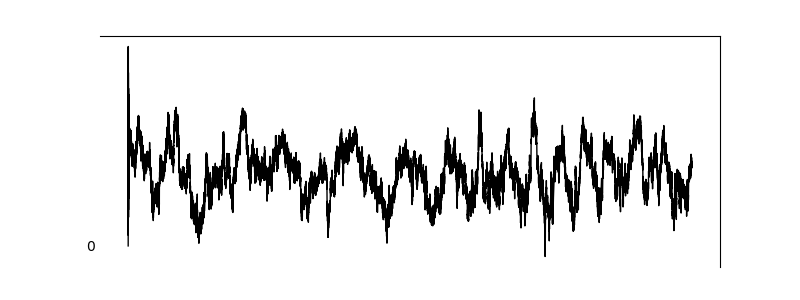

In [14]:
from neuropy.plotting.signals import plot_signal_traces
_, ax = plt.subplots(figsize=(8, 3))
plot_signal_traces(signal.time_slice(t_start=0, t_stop=3), ax=ax)